In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
def load_data(file_path):
    """Load dataset from a CSV file."""
    return pd.read_csv(file_path)

def preprocess_text(text):
    """Preprocess text by converting to lowercase, removing punctuation and numbers, and removing stopwords."""
    stop_words = set(stopwords.words('english'))
    text = text.lower()
    text = ''.join([char for char in text if char.isalpha() or char.isspace()])
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

def preprocess_data(data):
    """Apply preprocessing to the review column and create a new column 'cleaned_review'."""
    data['cleaned_review'] = data['review'].apply(preprocess_text)
    return data

In [ ]:
def extract_keywords(data):
    """Extract keywords using TF-IDF and return the TF-IDF DataFrame and feature names."""
    tfidf_vectorizer = TfidfVectorizer(max_features=100)
    tfidf_matrix = tfidf_vectorizer.fit_transform(data['cleaned_review'])
    feature_names = tfidf_vectorizer.get_feature_names_out()
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
    return tfidf_df, feature_names

def analyze_sentiment(text):
    """Analyze sentiment using VADER and return the compound sentiment score."""
    sia = SentimentIntensityAnalyzer()
    sentiment_score = sia.polarity_scores(text)
    return sentiment_score['compound']

def sentiment_analysis(data):
    """Apply sentiment analysis to the review column and add the results to a new column."""
    data['sentiment_score'] = data['review'].apply(analyze_sentiment)
    data['predicted_sentiment'] = data['sentiment_score'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral')
    return data

def calculate_importance(data, tfidf_df, feature_names):
    """Calculate importance by aggregating sentiment scores and frequency of keywords."""
    keyword_sentiments = {word: [] for word in feature_names}

    for index, row in data.iterrows():
        for word in row['cleaned_review'].split():
            if word in keyword_sentiments:
                keyword_sentiments[word].append(row['sentiment_score'])

    keyword_avg_sentiment = {word: sum(sentiments) / len(sentiments) for word, sentiments in keyword_sentiments.items() if sentiments}
    keyword_frequency = tfidf_df.sum().to_dict()

    importance_df = pd.DataFrame({
        'keyword': keyword_frequency.keys(),
        'frequency': keyword_frequency.values(),
        'sentiment': [keyword_avg_sentiment[word] for word in keyword_frequency.keys()]
    })

    return importance_df


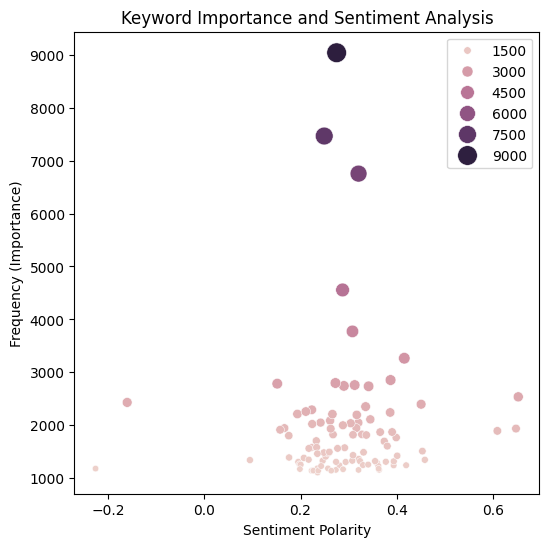

Sentiment Analysis Results:
predicted_sentiment
positive    32962
negative    17007
neutral        31
Name: count, dtype: int64

Sample of Predictions:
                                              review predicted_sentiment
0  One of the other reviewers has mentioned that ...            negative
1  A wonderful little production. <br /><br />The...            positive
2  I thought this was a wonderful way to spend ti...            positive
3  Basically there's a family where a little boy ...            negative
4  Petter Mattei's "Love in the Time of Money" is...            positive
5  Probably my all-time favorite movie, a story o...            positive
6  I sure would like to see a resurrection of a u...            positive
7  This show was an amazing, fresh & innovative i...            positive
8  Encouraged by the positive comments about this...            positive
9  If you like original gut wrenching laughter yo...            positive


In [ ]:
def visualize_importance(importance_df):
    """Visualize the relationship between sentiment, frequency, and keyword importance."""
    plt.figure(figsize=(6, 6))
    sns.scatterplot(data=importance_df, x='sentiment', y='frequency', hue='frequency', size='frequency', sizes=(20, 200))
    plt.title('Keyword Importance and Sentiment Analysis')
    plt.xlabel('Sentiment Polarity')
    plt.ylabel('Frequency (Importance)')
    plt.legend()
    plt.show()

def print_results(data):
    """Print the sentiment analysis results and a sample of the predictions."""
    print("Sentiment Analysis Results:")
    sentiment_counts = data['predicted_sentiment'].value_counts()
    print(sentiment_counts)

    print("\nSample of Predictions:")
    sample_predictions = data[['review', 'predicted_sentiment']].head(10)
    print(sample_predictions)

def main(file_path):
    """Main function to run the analysis pipeline."""
    data = load_data(file_path)
    data = preprocess_data(data)
    tfidf_df, feature_names = extract_keywords(data)
    data = sentiment_analysis(data)
    importance_df = calculate_importance(data, tfidf_df, feature_names)
    visualize_importance(importance_df)
    print_results(data)

if __name__ == "__main__":
    file_path = '/content/drive/MyDrive/Colab Notebooks/IMDB Dataset.csv'  # Replace with the actual file path
    main(file_path)
